In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ELU
from keras.layers import Lambda, Dense, Dropout, Flatten
from keras.initializers import RandomUniform
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import ELU
from keras.optimizers import Adam
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
# Global Vars
img = (cv.imread('../train/photos/images/gray_Clipped/0.jpg')).shape
img_height = img[0]
img_width = img[1]
img_channels = img[2]
print(img, img_height, img_width, img_channels)

(136, 320, 3) 136 320 3


In [3]:
def adjust_Value(prvs_FRAME, curr_FRAME, HSV_value):
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_BGR2HSV)
    prvs_FRAME[...,2] = prvs_FRAME[...,2]*HSV_value
    curr_FRAME[...,2] = curr_FRAME[...,2]*HSV_value
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_HSV2BGR)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_HSV2BGR)
    return prvs_FRAME, curr_FRAME

In [4]:
def opticalFlow_DENSE(prvs_FRAME, curr_FRAME, dynamic_sat):
    # flow_mat = None
    # image_scale = 0.5
    # pyr_images = 1 # was 3
    # win_size = 15
    # pyr_iterations = 2 # was 3
    # poly_expans = 5
    # std = 1.3 # was 1.2
    
    flow_mat = None
    image_scale = 0.5
    pyr_images = 1 # was 3
    win_size = 13
    pyr_iterations = 2 # was 3
    poly_expans = 5
    std = 1.3 # was 1.2

    hsv = np.zeros_like(prvs_FRAME)
    if dynamic_sat:
        hsv[..., 1] = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)[...,1]
    else:
        hsv[...,1] = 255
    prvs_FRAME = cv.cvtColor(prvs_FRAME,cv.COLOR_BGR2GRAY)
    curr_FRAME = cv.cvtColor(curr_FRAME,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs_FRAME,curr_FRAME,flow_mat,image_scale,pyr_images,win_size,pyr_iterations,poly_expans,std,0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
#     hsv = np.asarray(hsv, dtype=np.float32)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    return bgr

In [5]:
def getData(train_meta, kLoopCount, train_index, getSpeed, for_training):
    global img_height, img_width, img_channels
    opt_flows = np.empty((0, img_height, img_width, img_channels), dtype='float32')
    speed = np.empty((0))
    for k in range(kLoopCount):
        HSV_value = np.random.uniform(low=.5, high=1.2)
        #print(train_index)
        curr_FRAME = cv.imread(train_meta['image_path'][train_index])
        prvs_FRAME = cv.imread(train_meta['image_path'][train_index-1])
        if getSpeed:
            speed1 = train_meta['speed'][train_index]
            speed2 = train_meta['speed'][train_index-1]
            speed3 = np.mean((speed1, speed2))
            speed = np.append(speed, speed1)
        if for_training:
            prvs_FRAME, curr_FRAME = adjust_Value(prvs_FRAME, curr_FRAME, HSV_value)
        opt_flow = opticalFlow_DENSE(prvs_FRAME, curr_FRAME, False)
#         opt_flows = np.append(opt_flows, [opt_flow], axis=0)
        opt_flows = np.append(opt_flows, [np.asarray(opt_flow, dtype=np.float32)], axis=0)
    if getSpeed:
        return opt_flows, speed
    else:
        return opt_flows

In [6]:
def getTrainingData(train_meta, train_index, batchSize):
    global img_height, img_width, img_channels
    get_speed = True
    for_training = False
    while True:
        opt_flow_arr = np.empty((0, img_height, img_width, img_channels))
        speed_arr = np.empty((0))
        for i in range(batchSize):
            index = np.random.randint(0, train_index.shape[0])
            opt_flow, speed = getData(train_meta, 1, train_index[index], get_speed, for_training)
            opt_flow_arr = np.append(opt_flow_arr, opt_flow, axis=0)
            speed_arr = np.append(speed_arr, speed)
        #print(opt_flow_arr.shape)
        yield opt_flow_arr, speed_arr

In [7]:
def getValData(train_meta, val_index, batchSize, getSpeed):
    for_training = False
    while True:
        index = 0
        for i in range(len(val_index)):
            if getSpeed:
                opt_flow, speed = getData(train_meta, 1, val_index[index], getSpeed, for_training)
            else:
                opt_flow = getData(train_meta, 1, val_index[index], getSpeed, for_training)
            #opt_flow_arr = np.append(opt_flow_arr, opt_flow)
            index = index + 1
            if getSpeed:
                yield opt_flow, speed
            else:
                yield opt_flow

In [8]:
def createCNNModel():
    global img_height, img_width, img_channels
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=(img_height, img_width, img_channels)))
    #model.add(Lambda(lambda x: x/255, input_shape=(img_height, img_width, img_channels)))
    #uniform_initializer = RandomUniform(minval=0.00001, maxval=0.0001, seed=None)
    model.add(Conv2D(filters=40, kernel_size=(5,5), strides=(2,2), activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=20, kernel_size=(5,5), strides=(2,2), activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=64, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=32, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=16, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    opt = Adam(learning_rate=1e-3, epsilon=1e-08)
    model.compile(optimizer=opt, loss='mse')
    
#     model = Sequential()
#     # normalization    
#     # perform custom normalization before lambda layer in network
#     model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = (img_height, img_width, img_channels)))

#     model.add(Conv2D(24, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
    
    
#     model.add(ELU())    
#     model.add(Conv2D(36, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
    
#     model.add(ELU())    
#     model.add(Conv2D(48, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
#     model.add(ELU())
#     model.add(Dropout(0.5))
#     model.add(Conv2D(64, (3, 3), 
#                      strides = (1,1), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
    
#     model.add(ELU())              
#     model.add(Conv2D(64, (3, 3), 
#                      strides= (1,1), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
              
              
#     model.add(Flatten())
#     model.add(ELU())
#     model.add(Dense(100, kernel_initializer = 'he_normal'))
#     model.add(ELU())
#     model.add(Dense(50, kernel_initializer = 'he_normal'))
#     model.add(ELU())
#     model.add(Dense(10, kernel_initializer = 'he_normal'))
#     model.add(ELU())
    
#     # do not put activation at the end because we want to exact output, not a class identifier
#     model.add(Dense(1, kernel_initializer = 'he_normal'))
    
#     # LR was 1e-4 and epsilon was 1e-08
#     adam = Adam(learning_rate=1e-3, epsilon=1e-08)
#     model.compile(optimizer = adam, loss = 'mse')
    
    return model

In [9]:
def a_print_fn(x):
    global train_name
    dic = {'lambd':'L', 'conv2':'C', 'max_p':'P', 'flatt':'F', 'dense':'De', 'dropo':'D'}
    dic2 = {'C':4, 'De':0}
    dic3 = {',':0, ')':1, ' ':0}
    if x[:5] in dic:
        symbol = dic[x[:5]]
        symbol_unit = ''
        index = 13
        commaSpace_count = 0
        if symbol in dic2:
            while True:
                symbol_num = x[index]
                if symbol_num not in dic3:
                    if commaSpace_count == dic2[symbol]:
                        symbol_unit = symbol_unit + symbol_num
                    index = index + 1
                else:
                    if commaSpace_count == dic2[symbol]:
                        break
                    commaSpace_count = commaSpace_count+1
                    index = index + 1
        train_name = train_name + '-' + symbol + symbol_unit
#         print(train_name)
    #print(x)

In [10]:
model_name = 'gray_Clipped'
# model_name = 'gray_Clipped'
batch_size = 40
epoch_num = 20
steps_per_epoch = 400

train_meta_loc = '../train/text/CSV'
train_meta_loc = os.path.join(train_meta_loc, 'trainGrayClipped_meta.csv')
test_meta_loc = '../test/text/CSV'
test_meta_loc = os.path.join(test_meta_loc, 'testGrayClipped_meta.csv')
print(batch_size, epoch_num, steps_per_epoch)
print(train_meta_loc, '\n', test_meta_loc, '\n')

asset_path = '../train/assets/models'
#train_name = f'model={model_name}_C24_C36_C48_D50_C64_C64_De100_De50_De10_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
#train_name = f'model={model_name}2_elu_C40P_C20P_D25_De128_D30_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
#train_name = f'model={model_name}_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}__3'
#train_name = f'model={model_name}_elu_C40_C20_D35_De128_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}__4'
#train_name = f'model={model_name}_elu_C40_C20_De128_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'

train_name = f'model={model_name}-elu'
model = createCNNModel()
model.summary(line_length=100, positions=[0.06,0.55,0.67,0.0], print_fn=a_print_fn)
model = 0
train_name_end = f'-batch={batch_size}-epoch={epoch_num}-step_epoch={steps_per_epoch}__2'
train_name = train_name + train_name_end
train_path = os.path.join(asset_path, train_name)

model_train_meta_loc = os.path.join(train_path, 'train_meta.csv')
model_test_meta_loc = os.path.join(train_path, 'test_meta.csv')
test_result_path = os.path.join(train_path, 'test.txt')
history_loc = os.path.join(train_path, 'history.p')
weights_loc = os.path.join(train_path, 'weights.h5')
tensorboard_loc = os.path.join(train_path, train_name)
print(history_loc, '\n', weights_loc, '\n', tensorboard_loc)

40 20 400
../train/text/CSV/trainGrayClipped_meta.csv 
 ../test/text/CSV/testGrayClipped_meta.csv 

../train/assets/models/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2/history.p 
 ../train/assets/models/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2/weights.h5 
 ../train/assets/models/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2


In [11]:
def start():
    global train_meta_loc, batch_size, epoch_num, steps_per_epoch, train_path
    train_meta = pd.read_csv(train_meta_loc)
    
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    dataset_frames_num = train_meta.shape[0]
    train_frames_num = int(.8*(dataset_frames_num-1))
    val_frames_num = int((dataset_frames_num - train_frames_num))
    print(train_frames_num, val_frames_num)
    
    
    train_index = data_index[:train_frames_num]
    val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
    print(train_index.shape, val_index.shape)
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    
    valid_generator = getValData(train_meta, val_index, batch_size, True)
    val_size = len(val_index)
    earlyStopping = EarlyStopping(monitor='val_loss', 
                                  patience=1, 
                                  verbose=1, 
                                  min_delta = 0.23,
                                  mode='min',)
    
    modelCheckpoint = ModelCheckpoint(weights_loc, 
                                      monitor = 'val_loss', 
                                      save_best_only = False, 
                                      mode = 'min', 
                                      verbose = 1,
                                     save_weights_only = True)
    
    tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                                write_graph=True, write_images=True)
    #callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]
    callbacks_list = [modelCheckpoint, tensorboard]
    
    model = createCNNModel()
    
    train_size = len(train_index)
    train_generator = getTrainingData(train_meta, train_index, batch_size)
    history = model.fit_generator(
            train_generator, 
            steps_per_epoch = steps_per_epoch, 
            epochs = epoch_num,
            callbacks = callbacks_list,
            verbose = 1,
            validation_data = valid_generator,
            validation_steps = val_size)

    print(history)
    pickle.dump(history.history, open(history_loc, "wb"))
    
    return model, history.history, valid_generator, val_size

In [12]:
model, history, valid_generator, val_size = start()

16319 4081
(16319,) (4080,)
Epoch 1/20
400/400 [==============================] - 255s 639ms/step - loss: 26.7297 - val_loss: 79.3365

Epoch 00001: saving model to ../train/assets/models/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2/weights.h5
Epoch 2/20
400/400 [==============================] - 250s 625ms/step - loss: 9.4931 - val_loss: 0.6829

Epoch 00002: saving model to ../train/assets/models/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2/weights.h5
Epoch 3/20
400/400 [==============================] - 250s 624ms/step - loss: 7.8124 - val_loss: 1.3270

Epoch 00003: saving model to ../train/assets/models/model=gray_Clipped-elu-L-C40-P-C20-P-F-De128-De64-De32-De16-De1-batch=40-epoch=20-step_epoch=400__2/weights.h5
Epoch 4/20
400/400 [==============================] - 250s 624ms/step - loss: 5.7279 - val_loss: 0.9690

Epoch 00004: saving model to ../train/assets/models/model=gra

In [ ]:
#history = pickle.load(open(history_loc, "rb" ))
model = createCNNModel()
model.load_weights(weights_loc)
# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(optimizer = adam, loss = 'mse')

In [13]:
train_meta = pd.read_csv(train_meta_loc)

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
#train_frames_num = int(.8*(dataset_frames_num-1))
train_frames_num = int(.8*(dataset_frames_num-1))
val_frames_num = int(((dataset_frames_num-1) - train_frames_num))
test_frames_num = int(((dataset_frames_num-1) - (train_frames_num + val_frames_num)))
print(train_frames_num, val_frames_num, test_frames_num)

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
# test_index = data_index[(train_frames_num+val_frames_num):]
train_generator = getValData(train_meta, train_index, batch_size, True)
valid_generator = getValData(train_meta, val_index, batch_size, True)
# test_generator = getValData(train_meta, test_index, batch_size, True)
train_size = len(train_index)
val_size = len(val_index)
# test_size = len(test_index)

16319 4080 0


In [14]:
train_score = model.evaluate(train_generator, steps=train_size)
print('train score:', train_score)

16319/16319 [==============================] - 162s 10ms/step
train score: 0.25492990016937256


In [15]:
val_score = model.evaluate(valid_generator, steps=val_size)
print('val score:', val_score)

4080/4080 [==============================] - 40s 10ms/step
val score: 1.1481343507766724


In [ ]:
test_score = model.evaluate(test_generator, steps=test_size)
print('test score:', test_score)

In [ ]:
print('train score:', train_score)
print('val score:', val_score)
#print('test score:', test_score)

In [ ]:
print('train score:', train_score)
print('val score:', val_score)
print('test score:', test_score)

In [ ]:
history = pickle.load(open(history_loc, "rb" ))

In [ ]:
plt.plot(history['loss'], 'ro')
plt.plot(history['val_loss'], 'go')

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
fig_size2 = plt.rcParams["figure.figsize"]
print(fig_size2)

In [ ]:
train_meta = pd.read_csv(train_meta_loc)

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
train_frames_num = int(.70*(dataset_frames_num-1))

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:]
print(train_index, val_index)
plt.plot(train_meta['speed'][train_index], 'ro')
plt.plot(train_meta['speed'][val_index], 'go')

In [16]:
def predictSpeed(a_meta, a_meta_loc, getSpeed, setError):
    global model_train_meta_loc, model_test_meta_loc, batch_size, weights_loc

    dataset_frames_num = a_meta.shape[0]
    print(dataset_frames_num)
    
    data_index = np.arange(1, (dataset_frames_num))
    data_length = data_index.shape[0]
    print(data_length)
    
    data_gen = getValData(a_meta, data_index, batch_size, getSpeed)
    
    model = createCNNModel()
    model.load_weights(weights_loc)
    
    predicted_speed = model.predict(data_gen, steps=data_length, verbose=1)
    predicted_speed.shape = dataset_frames_num-1
    
    a_meta = a_meta.assign(predicted_speed=pd.Series(np.empty((dataset_frames_num))).values)
    a_meta.loc[:, 'predicted_speed'] = np.nan
    a_meta.loc[1:,'predicted_speed'] = predicted_speed
    
    if setError:
        a_meta = a_meta.assign(error=pd.Series(np.empty((dataset_frames_num))).values)
        a_meta.loc[:, 'error'] = np.nan
        a_meta.loc[1:,'error'] = abs(a_meta.loc[1:, 'speed'] - predicted_speed)

    a_meta.to_csv(a_meta_loc, index=False)

In [17]:
predictSpeed(train_meta, model_train_meta_loc, False, True)

20400
20399
20399/20399 [==============================] - 200s 10ms/step


In [18]:
train_meta = pd.read_csv(model_train_meta_loc)

In [ ]:
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed']))

In [ ]:
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed2']))

In [ ]:
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed3']))

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(train_meta[1000:2000])

In [ ]:
train_meta = train_meta.loc[:, :'error']

In [ ]:
train_meta.to_csv(model_train_meta_loc, index=False)

In [ ]:
np.mean(train_meta.loc[:,'error'])

In [ ]:
np.mean(train_meta.loc[:,'med_error'])

In [ ]:
np.mean(train_meta.loc[:,'mean_error'])

In [ ]:
print(train_meta.loc[20376:, 'predicted_speed'])

In [19]:
weighted_range = 100 # was 50
#train_meta = train_meta.assign(med_prd_spd=pd.Series(np.empty((20400))).values)
train_meta.loc[:, 'med_prd_spd'] = np.nan
train_meta.loc[1:,'med_prd_spd'] = train_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).median()
train_meta.loc[1:50, 'med_prd_spd'] = train_meta.loc[1:50, 'predicted_speed'] # was 25
train_meta.loc[20351:, 'med_prd_spd'] = train_meta.loc[20351:, 'predicted_speed'] # was 20376
#train_meta.to_csv(model_train_meta_loc, index=False)

In [20]:
#train_meta = train_meta.assign(med_error=pd.Series(np.empty((20400))).values)
train_meta.loc[:]['med_error'] = np.nan
train_meta.loc[1:,'med_error'] = abs(train_meta.loc[1:, 'speed'] - train_meta.loc[1:,'med_prd_spd'])

In [21]:
weighted_range = 100 # was 50
#train_meta = train_meta.assign(mean_prd_spd=pd.Series(np.empty((20400))).values)
train_meta.loc[:, 'mean_prd_spd'] = np.nan
train_meta.loc[1:,'mean_prd_spd'] = train_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).mean()
train_meta.loc[1:50, 'mean_prd_spd'] = train_meta.loc[1:50, 'predicted_speed'] # was 25
train_meta.loc[20351:, 'mean_prd_spd'] = train_meta.loc[20351:, 'predicted_speed'] # was 20376
#train_meta.to_csv(model_train_meta_loc, index=False)

In [22]:
#train_meta = train_meta.assign(mean_error=pd.Series(np.empty((20400))).values)
train_meta.loc[:]['mean_error'] = np.nan
train_meta.loc[1:,'mean_error'] = abs(train_meta.loc[1:, 'speed'] - train_meta.loc[1:,'mean_prd_spd'])

In [ ]:
train_meta.head()

In [23]:
train_meta.to_csv(model_train_meta_loc, index=False)

In [24]:
print(np.mean(train_meta.loc[:,'error']))
print(np.mean(train_meta.loc[:,'med_error']))
print(np.mean(train_meta.loc[:,'mean_error']))
print()
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed']))
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'med_prd_spd']))
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'mean_prd_spd']))

0.7740838162511628
0.4478309268811842
0.6387401495916956

3.700194748633999
1.0829312897812093
1.2353568158392512


In [25]:
data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
#train_frames_num = int(.8*(dataset_frames_num-1))
train_frames_num = int(.6*(dataset_frames_num-1))
val_frames_num = int(((dataset_frames_num-1) - train_frames_num))
test_frames_num = int(((dataset_frames_num-1) - (train_frames_num + val_frames_num)))
print(train_frames_num, val_frames_num, test_frames_num, train_frames_num+val_frames_num+test_frames_num)

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
#test_index = data_index[(train_frames_num+val_frames_num):]

12239 8160 0 20399


In [26]:
test1 = 0
test2 = 0
test3 = 0
for i in train_index:
    test1 = test1 + train_meta.loc[i, 'error']
test1_loss = test1/train_frames_num
for i in val_index:
    test2 = test2 + train_meta.loc[i, 'error']
test2_loss = test2/val_frames_num
# for i in test_index:
#     test3 = test3 + train_meta.loc[i, 'error']
# test3_loss = test3/test_frames_num

In [27]:
print(test1_loss, test2_loss)#, test3_loss)

0.7260219289669849 0.8461707572402619


In [28]:
test_meta = pd.read_csv(test_meta_loc)

In [29]:
predictSpeed(test_meta, model_test_meta_loc, False, False)

10798
10797
10797/10797 [==============================] - 106s 10ms/step


In [30]:
test_meta = pd.read_csv(model_test_meta_loc)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(test_meta[1080:1640])
    display(test_meta[-100:])

In [31]:
weighted_range = 100 # was 50
#test_meta = test_meta.assign(med_prd_spd=pd.Series(np.empty((20400))).values)
test_meta.loc[:, 'med_prd_spd'] = np.nan
test_meta.loc[1:,'med_prd_spd'] = test_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).median()
test_meta.loc[1:50, 'med_prd_spd'] = test_meta.loc[1:50, 'predicted_speed'] # was 25
test_meta.loc[10749:, 'med_prd_spd'] = test_meta.loc[10749:, 'predicted_speed'] # was 10774
#test_meta.to_csv(model_test_meta_loc, index=False)

In [32]:
weighted_range = 100 # was 50
#test_meta = test_meta.assign(mean_prd_spd=pd.Series(np.empty((20400))).values)
test_meta.loc[:, 'mean_prd_spd'] = np.nan
test_meta.loc[1:,'mean_prd_spd'] = test_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).mean()
test_meta.loc[1:50, 'mean_prd_spd'] = test_meta.loc[1:50, 'predicted_speed'] # was 25
test_meta.loc[10749:, 'mean_prd_spd'] = test_meta.loc[10749:, 'predicted_speed'] # was 10774
#test_meta.to_csv(model_test_meta_loc, index=False)

In [33]:
test_meta.to_csv(model_test_meta_loc, index=False)

In [34]:
stop_length = test_meta.loc[1080:1640].shape[0]

In [35]:
test1 = 0
test2 = 0
test3 = 0
for i in test_meta.loc[1080:1640, 'predicted_speed']:
    test1 = test1 + i
test1_loss = test1/stop_length
for i in test_meta.loc[1080:1640, 'med_prd_spd']:
    test2 = test2 + i
test2_loss = test2/stop_length
for i in test_meta.loc[1080:1640, 'mean_prd_spd']:
    test3 = test3 + i
test3_loss = test3/stop_length

In [36]:
print(test1_loss, test2_loss, test3_loss)

6.375015781617951 4.372067532649865 6.354640367172137


In [37]:
test_result = test_meta.loc[:, 'med_prd_spd']

In [38]:
type(test_result)

pandas.core.series.Series

In [39]:
test_result.to_csv(test_result_path, index=False)

In [40]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
fig_size2 = plt.rcParams["figure.figsize"]
print(fig_size2)

[6.0, 4.0]
[15.0, 10.0]


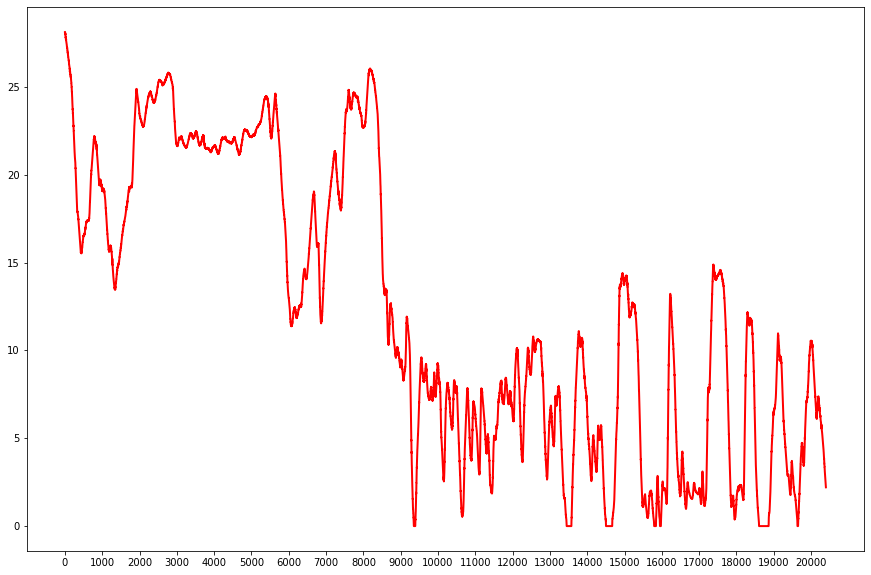

In [41]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'r', linewidth=2)
randomNumber = plt.xticks(np.arange(0, 20500, 1000))

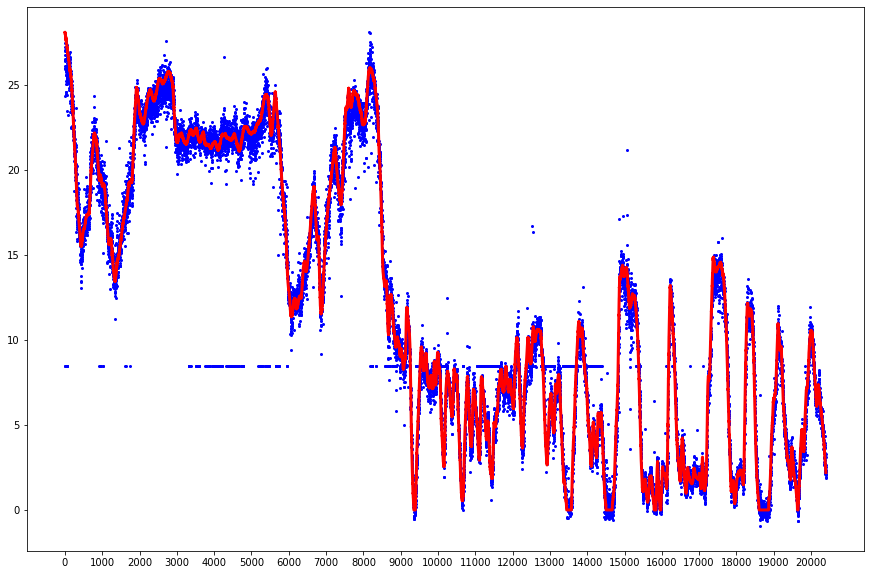

In [42]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'predicted_speed'], 'bo', markersize=2)
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'r', linewidth=3)
randomNumber = plt.xticks(np.arange(0, 20500, 1000))

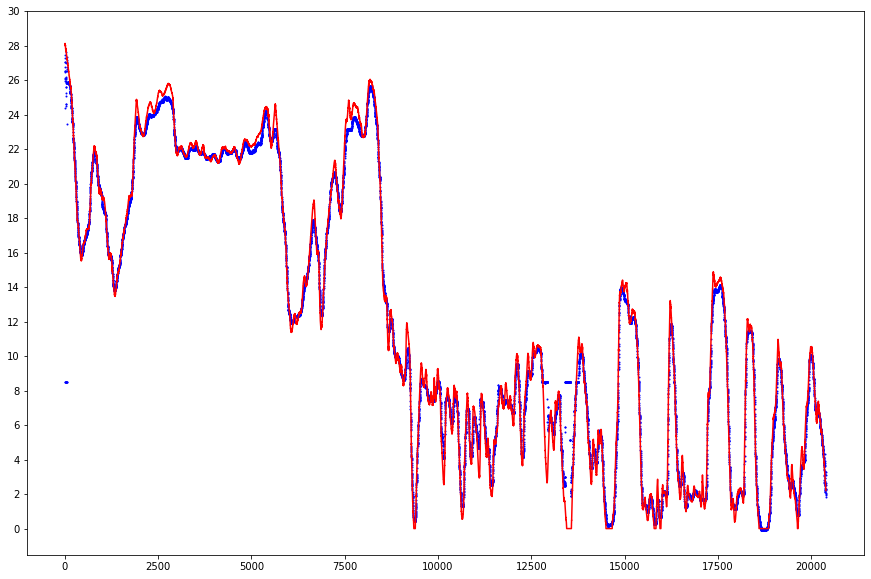

In [43]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'med_prd_spd'], 'bo', markersize=1)
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'r')
locs, labels = plt.xticks()
randomNumber = plt.yticks(np.arange(0, 32, 2))

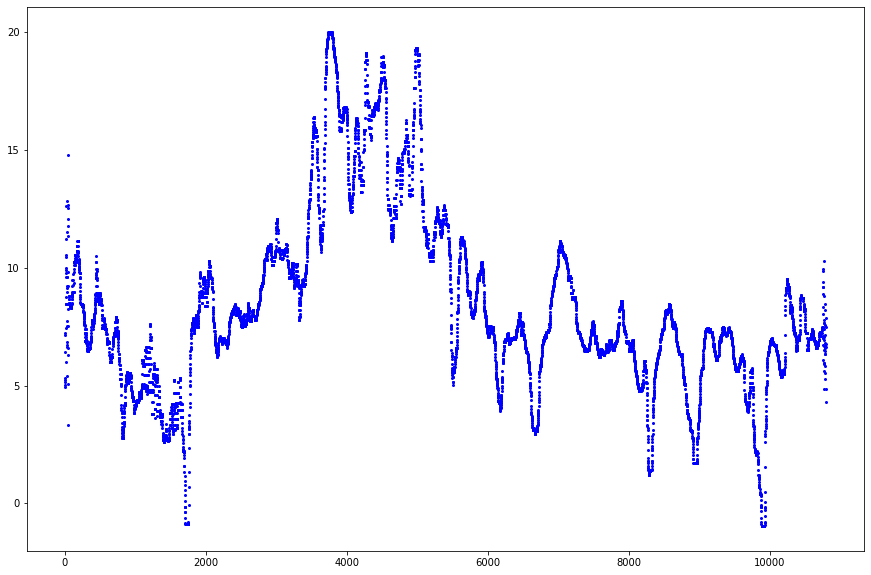

In [44]:
plt.plot(test_meta.loc[1:, 'image_index'], test_meta.loc[1:, 'med_prd_spd'], 'bo', markersize=2)

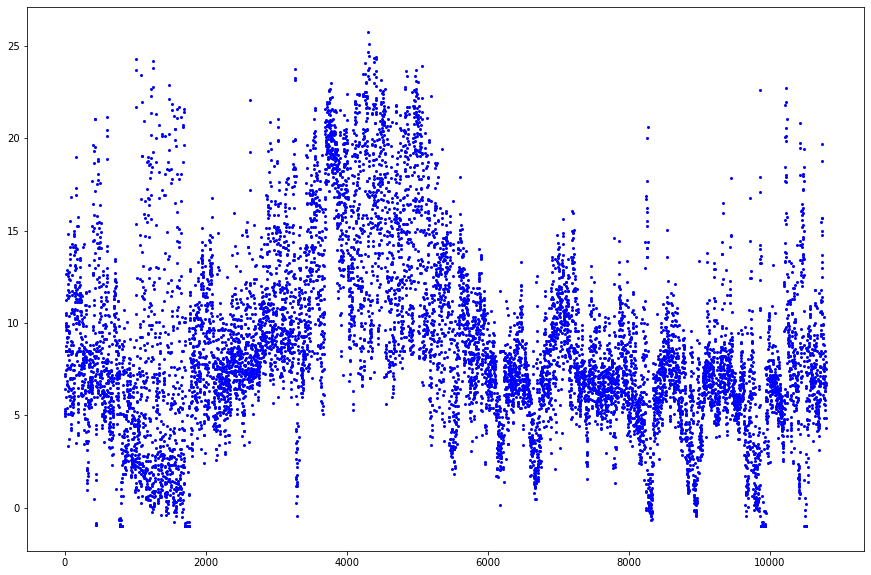

In [45]:
plt.plot(test_meta.loc[1:, 'image_index'], test_meta.loc[1:, 'predicted_speed'], 'bo', markersize=2)

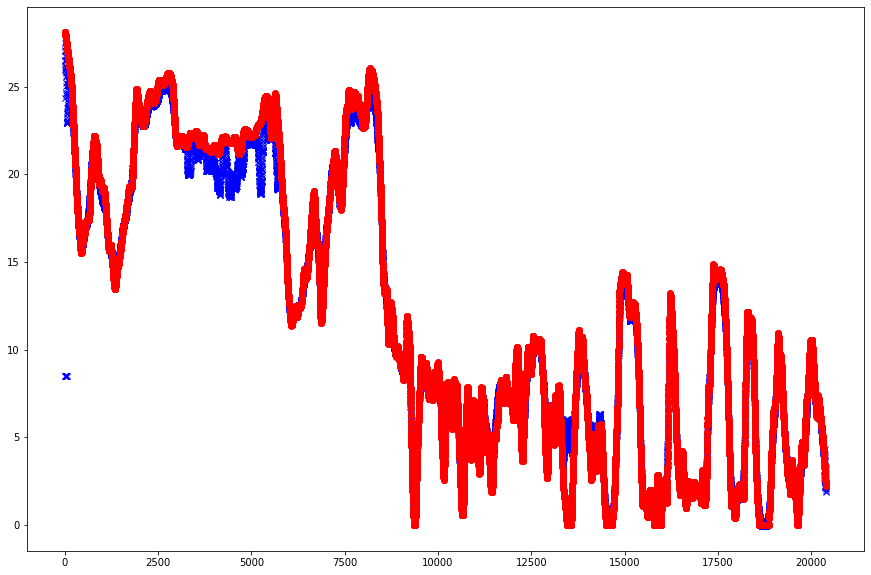

In [46]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'mean_prd_spd'], 'bx')
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'ro')

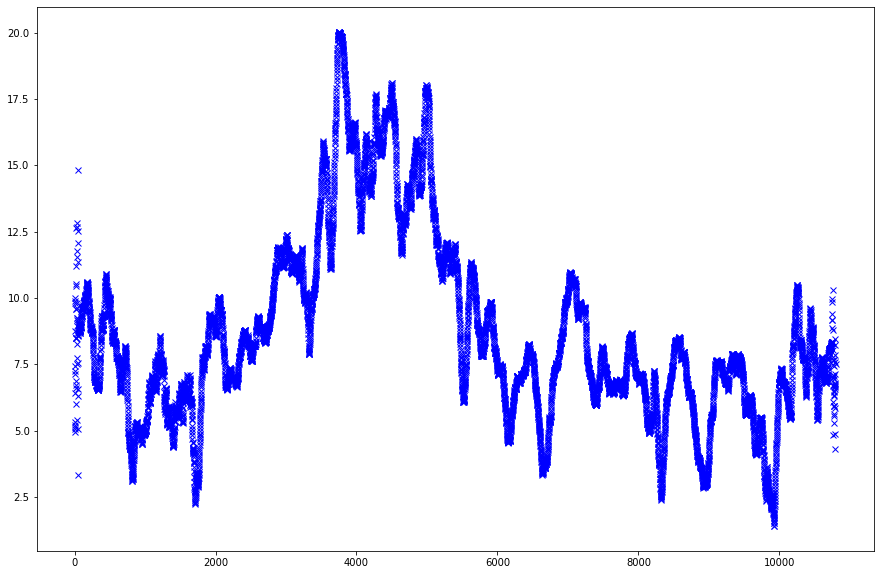

In [47]:
plt.plot(test_meta.loc[1:, 'image_index'], test_meta.loc[1:, 'mean_prd_spd'], 'bx')

In [ ]:
randomArray = test_meta.loc[:, 'predicted_speed']

In [ ]:
randomArray.shape

In [ ]:
randomArray2 = np.asarray(randomArray, dtype='float32')

In [ ]:
randomArray2.shape

In [ ]:
randomArray2[randomArray2 == 9.389342] = 2

In [ ]:
randomArray3 = randomArray2[randomArray2 == 2]

In [ ]:
randomArray3.shape